# Specific Test 4: Diffusion Models

### Name: Shashwat Srivastava
### Project: Diffusion Models for Gravitational Lensing Simulation (DeepLense)
### Evaluation Test Notebook

### Importing necessary libraries

In [106]:
# File navigation
import os
from pathlib import Path

# Neural network
import torch
from torch import nn, Tensor

# Data pipeline and cleaning
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda, functional, Resize

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Metrics
from torchmetrics.image.fid import FrechetInceptionDistance

# Miscellaneous
import numpy as np
import pandas as pd
from torchsummary import summary
from tqdm import tqdm
from math import sqrt
from IPython.display import clear_output
from typing import List, Tuple

### Basic settings

In [166]:
plt.style.use('dark_background')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
T = 1000                    # number of noising timesteps
print(f'Device being used: {device}')

Device being used: mps


### Utility functions

In [3]:
# Image transforms
transforms = Compose([torch.Tensor,
                    Lambda(lambda x:functional.convert_image_dtype(x,torch.float32))])
lr_transforms = Compose([Resize((32,32))])

# Switches from (B,H,W,C)=>(B,C,H,W) and vice-versa
ptb = lambda img,flg: (img.transpose(1,2).transpose(0,1) if flg==1 else img.transpose(0,1).transpose(1,2)) if len(img.shape)==3 else (img.transpose(2,3).transpose(1,2) if flg==1 else img.transpose(1,2).transpose(2,3))

# Scaling output from U-Net
scl = lambda x:(x+1)/2 if torch.min(x)<0 else x*2-1

# Unravelling for image attention
grpcon = lambda x:ptb(x,0).reshape(-1,ptb(x,0).shape[1]*ptb(x,0).shape[2],ptb(x,0).shape[3])

# Statistical variables provider based on noising routine
def sv(str, t, sch: str = 'linear') -> float | str:
    
    # Cosine Schedule
    if sch == 'cosine':
        ft = lambda t,s: np.cos((((t/T)+s)/(1+s))*(np.pi/2))**2
        a_t = ft(t,0.008)/ft(0,0.008)
        bt = 1-a_t/(ft(t-1,0.008)/ft(0,0.008))
        bt = 0.02 if bt>0.02 else bt
        at = 1-bt
        
    else: 
        # Linear Schedule
        bt=torch.linspace(0.0001,0.02,T)[t-1]
        at=1-bt
        a_t=torch.cumprod(1-torch.linspace(0.0001,0.02,T),dim=-1)[t-1]
        
    return bt if str=='bt' else (at if str=='at' else (a_t if str=='a_t' else 'nan'))

# Forward noising
def noising(x: Tensor, t: Tensor, sch: str = 'linear') -> Tuple[Tensor, Tensor]:
    noise = torch.randn_like(x)
    return torch.stack([(sv('a_t',t[i],sch)**0.5)*x[i]+((1-sv('a_t',t[i],sch))**0.5)*noise[i] for i in range(len(t))]), noise

### Data Visualization

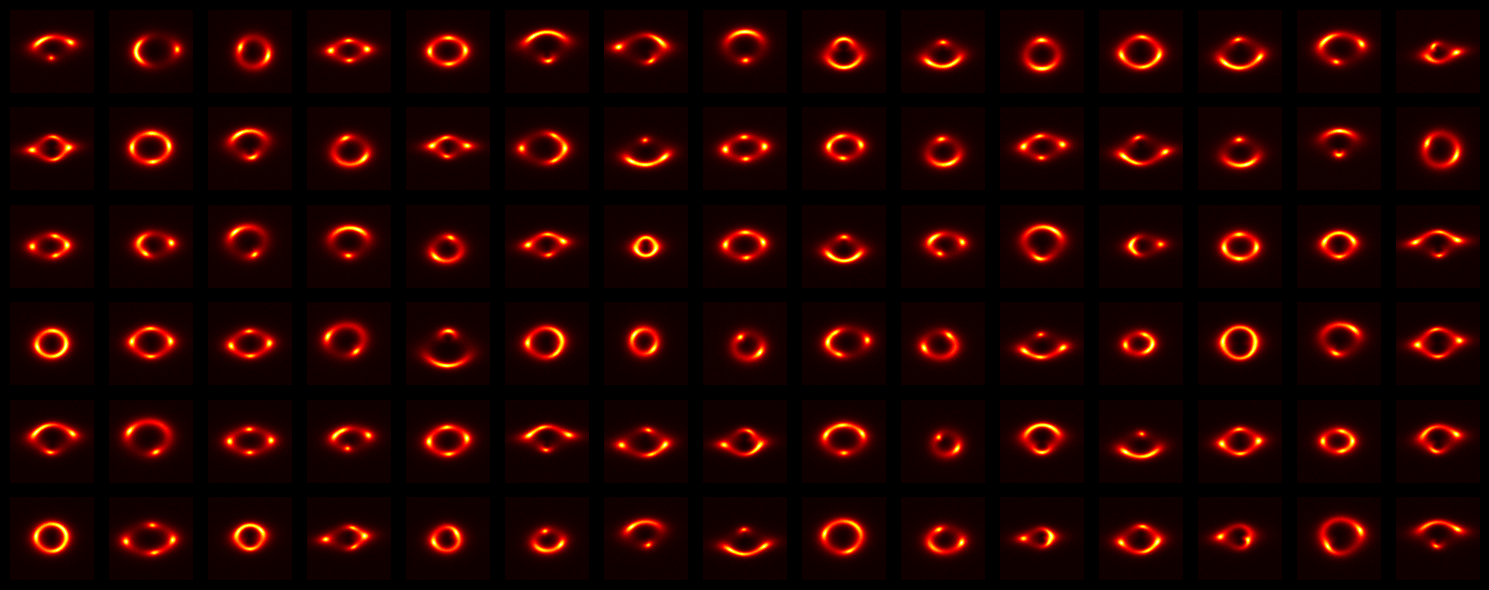

In [4]:
# Loading data
path=Path('datasets/Test 4')

grid = [6,15] # no. of images in each row and column of the grid (can be changed to anything)

# Plotting grid of images
fig, ax = plt.subplots(grid[0], grid[1], figsize = (grid[1],grid[0]))
for i, img in zip(range(grid[0]*grid[1]), path.iterdir()):
    ax[i//grid[1], i%grid[1]].imshow(np.load(img)[0], cmap='hot')
    ax[i//grid[1], i%grid[1]].axis('off')
plt.tight_layout()
plt.show()

### Data Pipeline

In [5]:
class data(Dataset):
    
    def __init__(self, transforms: Compose = None) -> None:
        
        self.path: Path = Path.cwd()/'datasets'/'Test 4' # Path object
        
        # Creating path list
        self.full_data: List[Path] = [file for file in self.path.iterdir()]
        
        self.transform = transforms # image transforms
        
    def __len__(self) -> int:
        return len(self.full_data)
    
    def __getitem__(self, i: int) -> Tensor:
        return self.transform(np.load(self.full_data[i]))

### Data Loader

In [167]:
dataloader = DataLoader(data(transforms), batch_size = 32, shuffle = True)

### Diffusion Process

The diffusion process has been divided into 3 steps:

1) Down scaling 150x150 image to 32x32
2) Generating 32x32 low resolution images using diffusion model
3) Up scaling the generated images back to 150x150 using a trained Decoder CNN model

This has been done to split the work for computational efficiency and better results in less training time

### Decoder training

#### Model architecture

In [7]:
class Decoder(nn.Module):
    
    blocke = lambda self,i,o,k,s,p: nn.Sequential(nn.Conv2d(i,o,k,s,p),nn.ReLU())
    blockd = lambda self,i,o,k,s,p: nn.Sequential(nn.ConvTranspose2d(i,o,k,s,p),nn.ReLU())
    
    def __init__(self) -> None:
        super(Decoder, self).__init__()

        self.e = nn.Sequential(self.blocke(1,32,3,2,1),
                             self.blocke(32,64,3,2,1),
                             self.blocke(64,128,3,2,1),
                             self.blocke(128,256,3,2,1))
        
        self.d = nn.Sequential(self.blockd(256,128,4,2,1),
                             self.blockd(128,64,3,2,1),
                             self.blockd(64,32,4,2,1),
                             self.blockd(32,16,3,2,1),
                             self.blockd(16,8,3,2,1),
                             nn.ConvTranspose2d(8,1,3,3,1),
                             nn.ReLU(),
                            nn.AdaptiveAvgPool2d(150))
        
    def forward(self, x: Tensor) -> Tensor:
        return self.d(self.e(x))
summary(Decoder(),(1,32,32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 256, 2, 2]         295,168
              ReLU-8            [-1, 256, 2, 2]               0
   ConvTranspose2d-9            [-1, 128, 4, 4]         524,416
             ReLU-10            [-1, 128, 4, 4]               0
  ConvTranspose2d-11             [-1, 64, 7, 7]          73,792
             ReLU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
             ReLU-14           [-1, 32,

#### Training initialization

In [9]:
dec = Decoder().to(device)                                 # sending model to device
optimizer = torch.optim.Adam(dec.parameters(), lr=0.0003)
l = nn.MSELoss()
dec.train()
epochs = 30

#### Training

In [115]:
for epoch in range(epochs):
    L=0
    for i ,img in enumerate(tqdm(dataloader, desc=f'Epochs: {epoch+1}/{epochs}', ncols=100)):
        
        optimizer.zero_grad()
        lr_img = lr_transforms(img)          # Reducing size of image from 150x150 to 32x32
        y_pred = dec(lr_img.to(device))
        loss = l(y_pred,img.to(device))
        loss.backward()
        
        with torch.no_grad():
            optimizer.step()
            L+=loss.item()
            
    print(f'Loss: {L/(i+1)}')

Epochs: 1/30: 100%|███████████████████████████████████████████████| 313/313 [00:28<00:00, 11.10it/s]


Loss: 0.00013039314326422567


Epochs: 2/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


Loss: 0.00012908636474890408


Epochs: 3/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.32it/s]


Loss: 0.00012986214968901033


Epochs: 4/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.25it/s]


Loss: 0.00012856756986290687


Epochs: 5/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.27it/s]


Loss: 0.0001271563707324587


Epochs: 6/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.34it/s]


Loss: 0.00012617511479496457


Epochs: 7/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


Loss: 0.00012515264039486497


Epochs: 8/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


Loss: 0.00012438863674111772


Epochs: 9/30: 100%|███████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


Loss: 0.00012372771578639323


Epochs: 10/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


Loss: 0.00012481924202296878


Epochs: 11/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


Loss: 0.00012264639134898175


Epochs: 12/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


Loss: 0.00012123694339973149


Epochs: 13/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


Loss: 0.00012162842041795728


Epochs: 14/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


Loss: 0.00012127635733186514


Epochs: 15/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


Loss: 0.00011917232905760758


Epochs: 16/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.20it/s]


Loss: 0.00012041590204975678


Epochs: 17/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.26it/s]


Loss: 0.00011758131049268435


Epochs: 18/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


Loss: 0.0001174072698190118


Epochs: 19/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


Loss: 0.00011867055056758743


Epochs: 20/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


Loss: 0.00011753998637759534


Epochs: 21/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


Loss: 0.00011652023458039572


Epochs: 22/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


Loss: 0.00011588558145986941


Epochs: 23/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


Loss: 0.00011658572263888474


Epochs: 24/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


Loss: 0.00011572039420861518


Epochs: 25/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.31it/s]


Loss: 0.00011638543326236581


Epochs: 26/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


Loss: 0.00011478241517884692


Epochs: 27/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.43it/s]


Loss: 0.00011422684843991898


Epochs: 28/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.35it/s]


Loss: 0.00011327438655840501


Epochs: 29/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


Loss: 0.0001133392620881939


Epochs: 30/30: 100%|██████████████████████████████████████████████| 313/313 [00:27<00:00, 11.20it/s]

Loss: 0.0001139450076431521


#### Saving model parameters

In [116]:
torch.save(dec.state_dict(), 'chkpt_Dec.pt')

#### Loading saved model parameters

In [10]:
dec.load_state_dict(torch.load('chkpt_Dec.pt'))

<All keys matched successfully>

### Diffusion U-Net

#### Model Architecture

##### Self-attention module

In [11]:
class Attention(nn.Module):
    
    def __init__(self, n: int) -> None:
        super(Attention, self).__init__()
        self.q = nn.Linear(n,n,bias=False)   # Query
        self.k = nn.Linear(n,n,bias=False)   # Key
        self.v = nn.Linear(n,n,bias=False)   # Value
        
    def forward(self, x: Tensor) -> Tensor:
        out=grpcon(x)                        # Unravelling
        Q=self.q(out)
        K=self.k(out)
        V=self.v(out)
        return ptb((torch.softmax((Q@K.transpose(1,2))/(x.shape[1])**0.5,1)@V).reshape(ptb(x,0).shape),1)

##### U-Net Architecture

In [12]:
class Model(nn.Module):
    
    blocke = lambda self,i,o,k,s,p: nn.Sequential(nn.Conv2d(i,o,k,s,p),nn.GroupNorm(4,o),nn.SiLU())
    blockd = lambda self,i,o,k,s,p: nn.Sequential(nn.Upsample(scale_factor=4),nn.Conv2d(i,o,k,s,p),nn.GroupNorm(4,o),nn.SiLU())

    # Positional timestep embeddings
    @torch.no_grad()
    def timemb(self, x: Tensor, t: Tensor) -> Tensor:
        dim = torch.tensor(10)
        emb = torch.tensor([[torch.sin(t[j]/(10000**(2*i*(1/dim)))) if i%2==0 else torch.cos(t[j]/(10000**(2*i*(1/dim)))) for i in range(dim)] for j in range(len(t))])
        return torch.relu(nn.Linear(dim,x.shape[1])(emb).unsqueeze(2).unsqueeze(3)).to(device)
        
    def __init__(self) -> None:
        
        super(Model, self).__init__()

        # Initializing attention blocks
        self.attn1 = Attention(256)
        self.attn2 = Attention(512)
        self.attn3 = Attention(512)

        # UNet architecture
        self.l1 = self.blocke(1,128,3,1,1) # --> 32x32x128 
        self.l2 = self.blocke(128,128,3,2,1) # --> 16x16x128
        self.l3 = self.blocke(128,256,3,1,1) # --> 16x16x256 (Attention)
        self.l4 = self.blocke(256,256,3,2,1) # --> 8x8x256
        self.l5 = self.blocke(256,512,3,1,1) # --> 8x8x512
        self.l6 = self.blocke(512,512,3,2,1) # --> 4x4x512   (Attention)
        self.l7 = self.blocke(512,512,3,1,1) # --> 4x4x512
        self.l8 = self.blocke(512,512,3,1,1) # --> 4x4x512               l6
        self.l9 = self.blockd(512,512,3,2,1) # --> 8x8x512   (Attention) l5
        self.l10 = self.blockd(512,256,3,4,1) # --> 8x8x256              l4
        self.l11 = self.blockd(256,256,3,2,1) # --> 16x16x256            l3
        self.l12 = self.blockd(256,128,3,4,1) # --> 16x16x128            l2
        self.l13 = self.blockd(128,128,3,2,1) # --> 32x32x128            l1
        self.l14 = nn.Sequential(nn.Upsample(scale_factor=4),
                                 nn.Conv2d(128,1,3,4,1))      # --> 32x32x1
        
    def forward(self, x: Tensor, t: Tensor) -> Tensor:

        # Encoder block with positional timestep embeddings
        
        out = self.l1(x + self.timemb(x,t))
        res1 = out
        out = self.l2(out + self.timemb(out,t))
        res2 = out
        out = self.l3(out + self.timemb(out,t))
        out = self.attn1(out)
        res3 = out
        out = self.l4(out + self.timemb(out,t))
        res4 = out
        out = self.l5(out + self.timemb(out,t))
        res5 = out
        out = self.l6(out + self.timemb(out,t))
        out = self.attn2(out)
        res6 = out
        out = self.l7(out + self.timemb(out,t))

        # Decoder block with skip connections and timestep embeddings
        
        out = self.l8(out + self.timemb(out,t)) + res6
        out = self.attn3(out)
        out = self.l9(out + self.timemb(out,t)) + res5
        out = self.l10(out + self.timemb(out,t)) + res4
        out = self.l11(out + self.timemb(out,t)) + res3
        out = self.l12(out + self.timemb(out,t)) + res2
        out = self.l13(out + self.timemb(out,t)) + res1
        return self.l14(out + self.timemb(out,t))
        
model=Model()
print(f'Total no. of trainable model parameters: {sum([p.numel() for p in model.parameters()])}')

Total no. of trainable model parameters: 15644929


#### Training initialization

In [13]:
rev_diff = Model().to(device)     # Reverse diffusion model
l = nn.MSELoss()
optimizer = torch.optim.Adam(rev_diff.parameters(), lr=0.0001)
epochs = 20

#### Training

In [24]:
for epoch in range(epochs):
    L=0
    for i, x in enumerate(tqdm(dataloader, desc=f"Epoch: {epoch+1}/{epochs}")):
        
        optimizer.zero_grad()
        t = torch.randint(1, T, (x.shape[0],))                     # Random timestep batch
        x_noisy, noise = noising(lr_transforms(x), t, 'linear')    # forward noising
        noise_pred = rev_diff(x_noisy.to(device), t.to(device))    # predicting noise in the image
        loss = l(noise.to(device), noise_pred)                     # MSE loss calculation
        loss.backward()                                            # Gradient calculation
        
        with torch.no_grad():
            optimizer.step()
            L+=loss.item()
            
    print ('Loss: %.10f'%(L/(i+1)))

The training sessions in the above cell is not visible because this model was trained on a cloud GPU service which returned the trained model weights. Due to limitation of the avvailable compute power, the weights have directly been loaded to show results. The results can be replicated by running the required training cells on better devices.

#### Saving model parameters 

In [ ]:
torch.save(rev_diff.state_dict(), 'chkpt_unet.pt')

#### Loading saved model parameters

In [14]:
rev_diff.load_state_dict(torch.load('chkpt_unet.pt'))

<All keys matched successfully>

### DDPM Sampling

#### Sampler

In [15]:
@torch.no_grad()
def sample_DDPM(xT: Tensor, ts: int = T): # ts is the no. of timesteps after which sampling should stop
    
    gif = list()    # for storing denoising frames

    # Initial denoising step
    x = (1/(sv('at',T))**0.5)*(xT.to(device)-rev_diff(xT.to(device),torch.tensor(T).unsqueeze(0).to(device))*(sv('bt',T)/((1-sv('a_t',T))**0.5)))+sv('bt',T)*torch.randn_like(xT).to(device)
    m = x[0]-torch.stack([torch.min(x[0][i]) for i in range(1)]).unsqueeze(1).unsqueeze(2).to(device)
    gif.append(m/torch.stack([torch.max(m[i]) for i in range(1)]).unsqueeze(1).unsqueeze(2).cpu().numpy()*255)

    # Denoising loop
    for t in range(T-1,1,-1):
        x = (1/(sv('at',t))**0.5)*(x-rev_diff(x,torch.tensor(t).unsqueeze(0).to(device))*(sv('bt',t)/((1-sv('a_t',t))**0.5)))+sv('bt',t)*torch.randn_like(x).to(device)
        m = x[0]-torch.stack([torch.min(x[0][i]) for i in range(1)]).unsqueeze(1).unsqueeze(2).to(device)
        gif.append(m/torch.stack([torch.max(m[i]) for i in range(1)]).unsqueeze(1).unsqueeze(2).cpu().numpy()*255)
        if t == (T-ts):
            break
        
    return (1/(sv('at',1))**0.5)*(x-rev_diff(x,torch.tensor(1).unsqueeze(0))*(sv('bt',1)/((1-sv('a_t',1))**0.5))), gif

#### Sampling

In [20]:
with torch.no_grad():
    
    g = list()        # for storing samples
    nsamp = 100         # number of samples
    
    for i in tqdm(range(nsamp), desc=f'Generating {nsamp} Samples'):
        e = torch.randn(1,1,32,32)      # Gaussian noise
        gen,gif = sample_DDPM(e, 200)   # sample generation

        # Rescaling for visualization
        gen = gen[0] - torch.stack([torch.min(gen[0][i]) for i in range(1)]).unsqueeze(1).unsqueeze(2)
        gen = gen / torch.stack([torch.max(gen[i]) for i in range(1)]).unsqueeze(1).unsqueeze(2)
        g.append((gen,gif))

Generating 100 Samples: 100%|██████████████████████████████████████████████████████| 100/100 [06:54<00:00,  4.14s/it]


#### Plotting samples

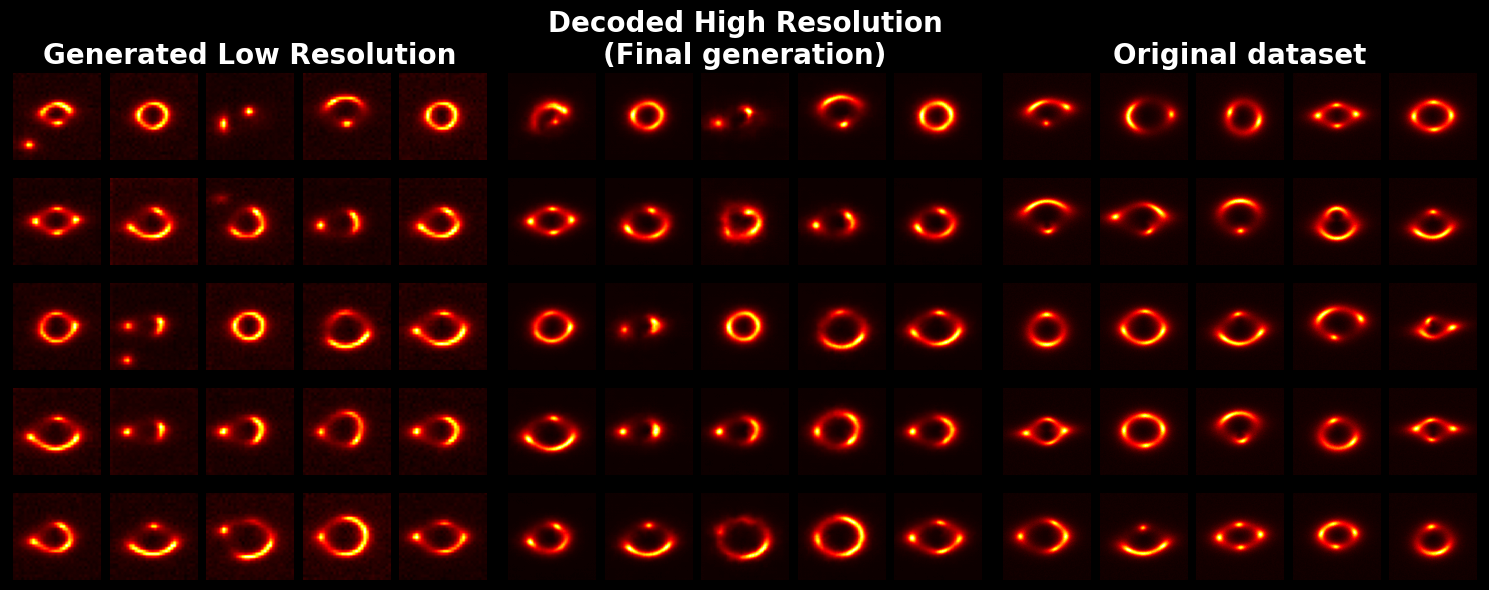

In [105]:
# Loading data
path=Path('datasets/Test 4')

fig = plt.figure(figsize = (15,6))
iax = gridspec.GridSpec(1, 3, figure=fig)
name = ['Generated Low Resolution', 'Decoded High Resolution\n(Final generation)', 'Original dataset']

# Python generators for each grid
g1 = (img for img,_ in g)
g2 = (dec(img).detach() for img,_ in g)
g3 = (np.load(img) for img in path.iterdir())
G = (g1, g2, g3)

grid = 5 # no. of images in each row and column of the grid (can be changed to anything)

# Plotting grid
for j, ax in enumerate(iax):
    out_ax = fig.add_subplot(ax)
    out_ax.set_title(f'{name[j]}', fontsize=20, fontweight='bold')
    out_ax.axis('off')
    it = G[j]
    jax = gridspec.GridSpecFromSubplotSpec(grid, grid, subplot_spec=ax)
    for i, img in zip(range(grid**2), it):
        in_ax = fig.add_subplot(jax[i//grid, i%grid])
        in_ax.imshow(img[0], cmap='hot')
        in_ax.axis('off')
plt.tight_layout()

### Animating denoising process

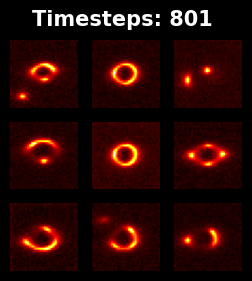

In [165]:
frames = [gif for _,gif in g]
grid_shape = [3,3]
for i in range(200):
    fig, ax = plt.subplots(grid_shape[0], grid_shape[1], figsize = (grid_shape[1],grid_shape[0]))
    for j, frame in zip(range(grid_shape[0]*grid_shape[1]),frames):
        ax[j//grid_shape[1],j%grid_shape[1]].imshow(frame[i][0], cmap='hot')
        ax[j//grid_shape[1],j%grid_shape[1]].axis('off')
    fig.suptitle(f'Timesteps: {T-i}', fontsize=15, fontweight='bold')
    plt.show()
    clear_output(wait=True)

### FID Score

In [28]:
# Making InceptionV3 compatible real and fake image tensors 
gen_imgs = (255 * torch.stack([dec(img).detach() for img,_ in g]).repeat(1, 3, 1, 1)).to(torch.uint8)
real_imgs = (255 * torch.stack([torch.from_numpy(np.load(img)) for i, img in enumerate(path.iterdir()) if i<=len(gen_imgs)-1]).repeat(1, 3, 1, 1)).to(torch.uint8)

# FID score calculation
fid_scores = list()
for feat in [64, 192, 768, 2048]:
    fid = FrechetInceptionDistance(feature=feat)  # setting feature map extracting layer of Inception V3
    fid.update(real_imgs, real=True)
    fid.update(gen_imgs, real=False)
    fid_scores.append(fid.compute().item())
print(f'FID Scores on {nsamp} sample images:')
pd.DataFrame({'InceptionV3 feature layer':[64, 192, 768, 2048],
             'FID Score':fid_scores})

FID Scores on 100 sample images:


,InceptionV3 feature layer,FID Score
0,64,0.629886
1,192,8.254849
2,768,0.632835
3,2048,79.372032
